In [1]:
from minio import Minio
from dotenv import load_dotenv
import os
import json
import pandas as pd

In [2]:
load_dotenv()

minio_client = Minio(
    endpoint=os.getenv("MINIO_ENDPOINT"),
    access_key=os.getenv("MINIO_ACCESS_KEY"), 
    secret_key=os.getenv("MINIO_SECRET_KEY"), 
    secure=False 
)
bucket_name = os.getenv("MINIO_BUCKET_NAME")
pasta_prefix = "Portalnoticiasceara/noticias_recentes_ultimos_180_dias" 

In [3]:
list_objects = minio_client.list_objects(bucket_name, prefix=pasta_prefix, recursive=True)

In [4]:
objetos = [minio_client.get_object(bucket_name=bucket_name, object_name=obj.object_name) for obj in list_objects if obj.object_name.endswith('metadata.json')]

In [5]:
dataframes = []
for response in objetos:
    data = response.read().decode('utf-8')
    
    json_data = json.loads(data)
    df = pd.json_normalize(json_data)
    dataframes.append(df)  
final_dataframe = pd.concat(dataframes, ignore_index=True)  

In [6]:
final_dataframe.head()

,id,mensagem,data,media_path,faccao,bairro
0,4277,"**Homicídio registrado na Av. Mister Hull, pró...",2024-11-24 22:11:15,[Portalnoticiasceara/past_dates/2024-11-25/med...,None,antonio_bezerra
1,4326,**Mulher chefe de grupo criminoso de origem ce...,2024-11-25 13:49:35,[Portalnoticiasceara/past_dates/2024-11-25/med...,None,meireles
2,6680,Homicídio a bala registrado neste domingo (29)...,2024-12-29 14:04:04,[],None,jardim_das_oliveiras
3,6691,**Polícia militar age rápido e apreende acusad...,2024-12-29 16:53:10,[],None,edson_queiroz
4,6665,"**Duplo Homicídio no Bairro Aracapé, em Fortal...",2024-12-29 09:59:53,[],GDE,planalto_ayrton_senna


In [7]:
final_dataframe.shape[0]

1022

In [8]:
final_dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1022.0,4101.601761,1713.137515,1027.0,2612.0,4151.5,5623.0,6957.0


In [9]:
len(final_dataframe[final_dataframe['faccao'] == 'GDE'])

114

In [10]:
len(final_dataframe[final_dataframe['faccao'] == 'CV'])

197

In [11]:
len(final_dataframe[final_dataframe['faccao'] == 'TDN'])

65

In [12]:
len(final_dataframe[final_dataframe['faccao'] == 'PCC'])

9

In [13]:
len(final_dataframe[final_dataframe['faccao'] == 'MASSA'])

0

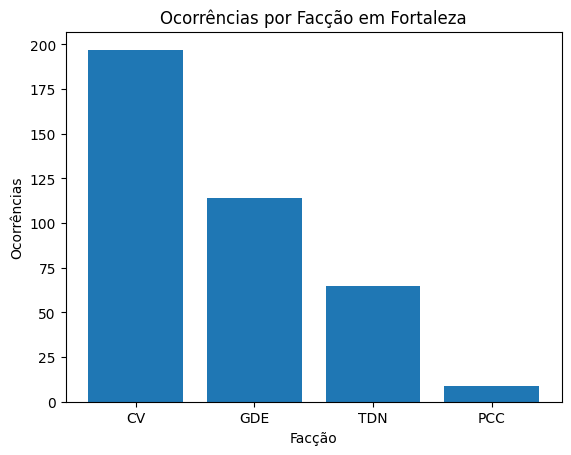

In [14]:
import matplotlib.pyplot as plt

counts = final_dataframe['faccao'].value_counts()

plt.bar(counts.index, counts.values)

plt.xlabel('Facção')
plt.ylabel('Ocorrências')
plt.title('Ocorrências por Facção em Fortaleza')

plt.show()

In [15]:
df_one_hot = pd.get_dummies(final_dataframe[['mensagem', 'faccao']], columns=['faccao'])

In [16]:
df_one_hot.head()

,mensagem,faccao_CV,faccao_GDE,faccao_PCC,faccao_TDN
0,"**Homicídio registrado na Av. Mister Hull, pró...",False,False,False,False
1,**Mulher chefe de grupo criminoso de origem ce...,False,False,False,False
2,Homicídio a bala registrado neste domingo (29)...,False,False,False,False
3,**Polícia militar age rápido e apreende acusad...,False,False,False,False
4,"**Duplo Homicídio no Bairro Aracapé, em Fortal...",False,True,False,False


In [17]:
df_filtered = df_one_hot[(df_one_hot[['faccao_CV', 'faccao_GDE', 'faccao_TDN', 'faccao_PCC']].sum(axis=1) > 0)]

##### Anotações
- Remoção de Pontuação e Caracteres Especiais:
    Remover caracteres especiais e pontuação que não são importantes para o modelo.
- Lowercasing:
    Converter o texto para minúsculas para evitar duplicação devido à diferença de maiúsculas/minúsculas.
- Tokenização:
    Dividir o texto em palavras ou tokens.
- Remoção de Stop Words:
    Eliminar palavras comuns, como "a", "e", "o", que não trazem valor informativo.
- Lematização ou Stemming:
    Reduzir palavras a suas formas base (ex: "correr" e "correu" para "correr").

In [21]:
#!chmod -R 755 ~/nltk_data
import string
import spacy
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import os

""" 
    Configurando nltk:
    - setando local de download e baixando todos os recursos necessários
    - punkt -> tokenização
    - punkt_tab -> ptbr
    - stopwords -> conjunto maior e pronto de stopwords
"""
nltk_data_path = os.path.expanduser('~/nltk_data')
os.environ['NLTK_DATA'] = nltk_data_path
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stopwords_pt = stopwords.words('portuguese')

nlp = spacy.load("pt_core_news_sm")

# PS: Pensado para a analise de tags de facções criminosas, apenas. 
def preprocess_text(text):
    text = text.lower() 
    text = ''.join([char for char in text if char not in string.punctuation]) 
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text, language='portuguese')
    tokens = [t for t in tokens if t not in stopwords_pt]
    tokens = [t for t in tokens if not t.isdigit()]
    tokens = [nlp(t)[0].lemma_ for t in tokens]
    return ' '.join(tokens)

df_filtered['mensagem'] = df_filtered['mensagem'].apply(preprocess_text)
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df_filtered['mensagem'])

[nltk_data] Downloading package punkt to
[nltk_data]     /home/nycolasdiaas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/nycolasdiaas/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nycolasdiaas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_35033/1368612717.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['mensagem'] = df_filtered['mensagem'].apply(preprocess_text)


In [25]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12940 stored elements and shape (385, 1000)>

In [26]:
vectorizer

TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df_filtered[['faccao_CV', 'faccao_GDE', 'faccao_TDN', 'faccao_PCC']], test_size=0.2, random_state=42)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier


lr = LogisticRegression(max_iter=1000)
model = MultiOutputClassifier(lr)
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [35]:
from sklearn.metrics import hamming_loss
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
loss = hamming_loss(y_test, y_pred)

print(f"Hamming Loss: {loss}")

Hamming Loss: 0.06818181818181818


In [42]:
comparison_df = pd.DataFrame(y_test.values, columns=y_test.columns)
comparison_df['mensagem'] = df_filtered.loc[y_test.index, 'mensagem'].values
comparison_df['faccao_pred_CV'] = y_pred[:, 0]
comparison_df['faccao_pred_GDE'] = y_pred[:, 1]
comparison_df['faccao_pred_TDN'] = y_pred[:, 2]
comparison_df['faccao_pred_PCC'] = y_pred[:, 3]

In [43]:
comparison_df

,faccao_CV,faccao_GDE,faccao_TDN,faccao_PCC,mensagem,faccao_pred_CV,faccao_pred_GDE,faccao_pred_TDN,faccao_pred_PCC
0,False,True,False,False,homicídio registrar Bairro novo Mondubim gde f...,False,False,False,False
1,False,False,True,False,atenção 🚨 homicídio registrar em este exato mo...,False,False,False,False
2,True,False,False,False,homicídio carlito pamplonar fortalezar noite d...,True,False,False,False
3,False,True,False,False,atenção 🚨 muito balar Bairro coaçu gde pacajus...,False,False,False,False
4,True,False,False,False,perseguição policial fortalezar tiro Avenida l...,True,False,False,False
...,...,...,...,...,...,...,...,...,...
72,False,True,False,False,identificação vítima diogo sério morador comun...,False,True,False,False
73,True,False,False,False,atenção 🚨 muito balar em este exato momento co...,True,False,False,False
74,False,True,False,False,atenção 🚨 homicídio em esse momento lagoa catã...,False,True,False,False
75,False,False,True,False,prisão realizar Bairro Jardim oliveira tdn for...,False,False,True,False


In [44]:
comparison_df.to_csv('pred.csv')

In [29]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_samples = f1_score(y_test, y_pred, average='samples')

print("F1 Weighted:", f1_weighted)
print("F1 Samples:", f1_samples)
print("F1 Micro:", f1_micro)
print("F1 Macro:", f1_macro)


F1 Weighted: 0.8242836975231341
F1 Samples: 0.7532467532467533
F1 Micro: 0.8467153284671532
F1 Macro: 0.6304622607439508


In [30]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

Acurácia: 0.7532467532467533


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred, average=None)  
recall = recall_score(y_test, y_pred, average=None)  
f1 = f1_score(y_test, y_pred, average=None)  

print("Precisão por classe:", precision)
print("Recall por classe:", recall)
print("F1 por classe:", f1)

Precisão por classe: [0.94444444 1.         1.         0.        ]
Recall por classe: [0.97142857 0.57575758 0.71428571 0.        ]
F1 por classe: [0.95774648 0.73076923 0.83333333 0.        ]


/home/nycolasdiaas/Projetos/zarea-de-risco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred, average='micro', multi_class='ovr')  # 'ovr' para One-vs-Rest
print("AUC:", roc_auc)


AUC: 0.8722943722943722


In [33]:
# !pip install seaborn matplotlib

Matriz de Confusão para a classe: faccao_CV
[[40  2]
 [ 1 34]]


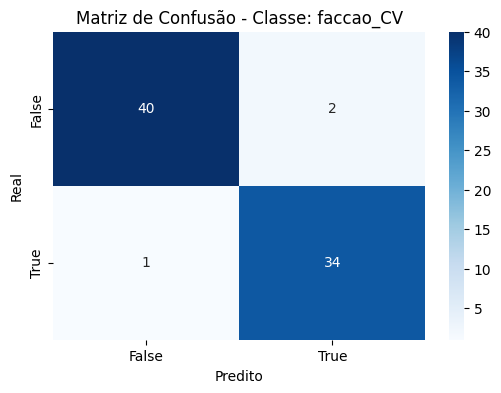

Matriz de Confusão para a classe: faccao_GDE
[[44  0]
 [14 19]]


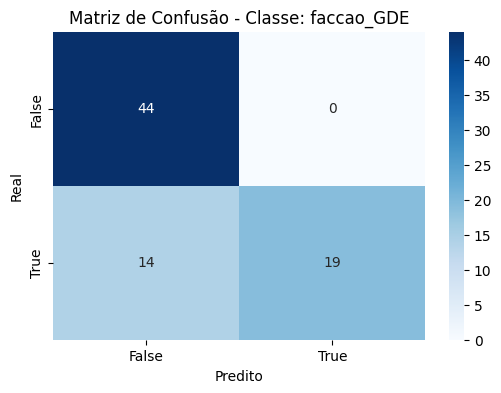

Matriz de Confusão para a classe: faccao_TDN
[[70  0]
 [ 2  5]]


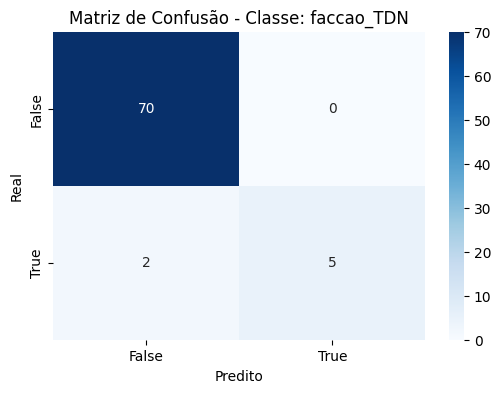

Matriz de Confusão para a classe: faccao_PCC
[[75  0]
 [ 2  0]]


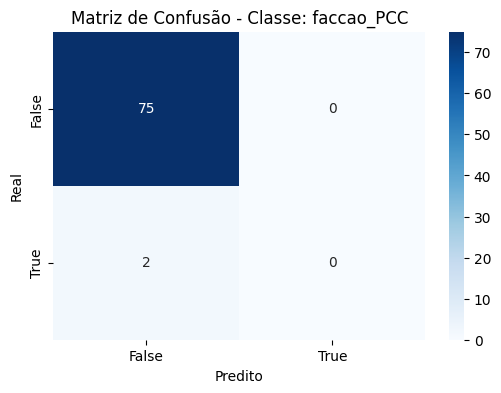

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


for i, column in enumerate(y_test.columns):
    print(f'Matriz de Confusão para a classe: {column}')
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title(f'Matriz de Confusão - Classe: {column}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
